# Flatmaps of final parcellation

In [1]:
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.export_atlas as ea
import ProbabilisticParcellation.scripts.parcel_hierarchy as ph
import ProbabilisticParcellation.scripts.evaluate_atlas as eva
import SUITPy as suit
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import torch as pt
import os
import nitools as nt

from pathlib import Path
import numpy as np
import Functional_Fusion.atlas_map as am
import scipy.linalg as sl
import nibabel as nb
import nitools as nt
import re
from copy import deepcopy
import PcmPy as pcm
from matplotlib.colors import ListedColormap


In [2]:
# Figure settings
figsize = (8, 8)
colorbar = False
bordersize = 4
blend = 0.8 # Strength of fade

background='white'
fontcolor='k'
bordercolor='k'
backgroundcolor='w'
fade = 1.0 

## Import MDTB parcellations from King 2019 paper

In [3]:
mdtb_17_file = ut.base_dir + '/../Cerebellum/ProbabilisticParcellationModel/Atlases/archive/old_server_mdtb_parcellations/glm4/groupEval_SC12_cnvf_17/map.nii'
mdtb_17 = nb.load(mdtb_17_file)
mdtb_10_file = ut.base_dir + '/../Cerebellum/ProbabilisticParcellationModel/Atlases/archive/old_server_mdtb_parcellations/glm4/groupEval_SC12_cnvf_10/map.nii'
mdtb_10 = nb.load(mdtb_10_file)
mdtb_7_file = ut.base_dir + '/../Cerebellum/ProbabilisticParcellationModel/Atlases/archive/old_server_mdtb_parcellations/glm4/groupEval_SC12_cnvf_7/map.nii'
mdtb_7 = nb.load(mdtb_7_file)


/Users/callithrix/code/Python/SUITPy/SUITPy/flatmap.py:354: RuntimeWarning: invalid value encountered in cast
  data_arr = data_arr.astype(int)


<Axes: >

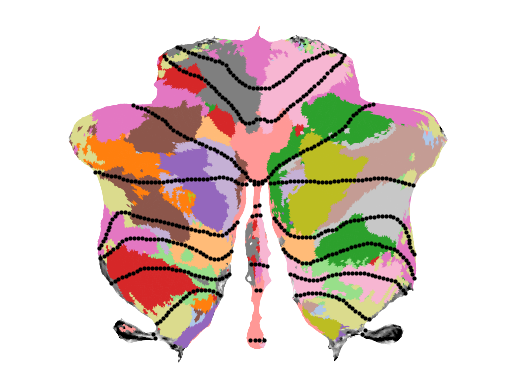

In [4]:
mdtb_17_surf = suit.flatmap.vol_to_surf(mdtb_17, stats='mode',
                                             space='SUIT')
suit.flatmap.plot(mdtb_17_surf,
    render='matplotlib',
    new_figure=False,
    overlay_type='label',
    cmap='tab20',
    colorbar=colorbar,
    bordersize=bordersize, bordercolor=bordercolor, backgroundcolor=backgroundcolor)

## Import NettekovenAsym32 parcellation

In [8]:
_, cmap, labels = nt.read_lut(ut.export_dir + 'NettekovenAsym32.lut')
atlas_file = ut.export_dir + 'NettekovenAsym32_space-MNISymC2_probseg.nii'
NettekovenAsym_probseg_img = nb.load(atlas_file)

# Load atlas in SUIT space to ensure compatability with MDTB parcellation
suit_atlas, _ = am.get_atlas('SUIT3')
NettekovenAsym_probseg = suit_atlas.read_data(atlas_file)
NettekovenAsym_dseg = np.argmax(NettekovenAsym_probseg, axis=1) + 1
NettekovenAsym_dseg_split = pcm.indicator(NettekovenAsym_dseg).T

<Axes: >

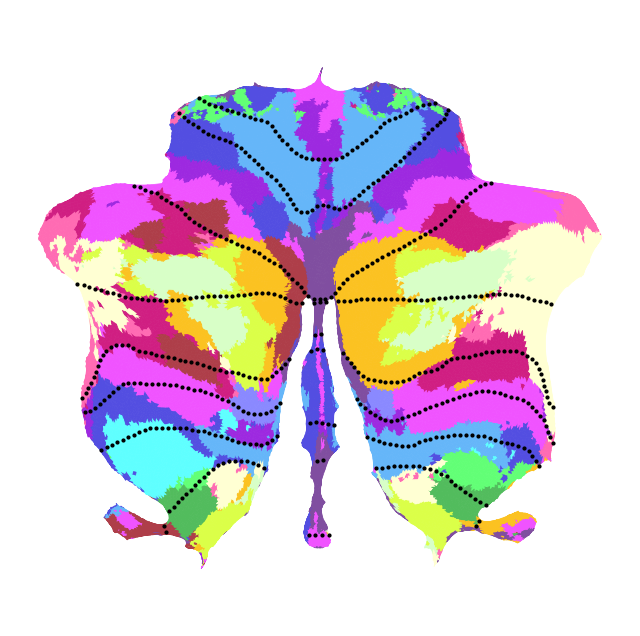

In [9]:
plt.figure(figsize=figsize)
nettekoven_asym_surf = suit.flatmap.vol_to_surf(NettekovenAsym_probseg_img, stats='nanmean',
                                             space='MNISymC')
nettekoven_asym_label = np.argmax(nettekoven_asym_surf, axis=1) + 1
suit.flatmap.plot(nettekoven_asym_label,
    render='matplotlib',
    cmap=cmap,
    new_figure=False,
    label_names=labels,
    overlay_type='label',
    colorbar=colorbar,
    bordersize=bordersize, bordercolor=bordercolor, backgroundcolor=backgroundcolor)

## Calculate ARI with King 2019 MDTB parcellation

In [11]:
# Import MDTB parcellations from 2019 paper
mdtb_7_dseg = suit_atlas.read_data(mdtb_7_file)
mdtb_10_dseg = suit_atlas.read_data(mdtb_10_file)
mdtb_17_dseg = suit_atlas.read_data(mdtb_17_file)

In [12]:
ari, ari_mean = ev.ARI_voxelwise(pt.tensor(NettekovenAsym_dseg).unsqueeze(1).T, pt.tensor(mdtb_17_dseg).unsqueeze(1).T)

Calculating Adjusted Rand Index...
Computing ARI at group-level...


<Axes: >

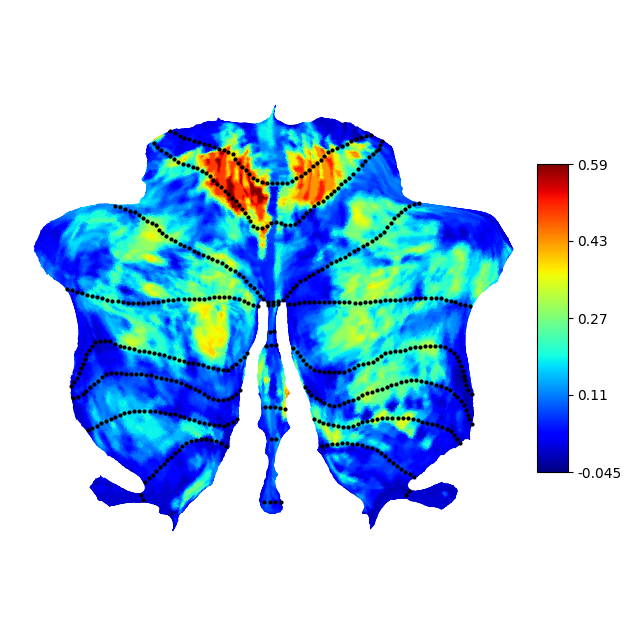

In [13]:
plt.figure(figsize=figsize)
ut.plot_data_flat(data=ari_mean, atlas='SUIT3',
                   dtype='func',
                   render='matplotlib',
                   bordersize=4,
                   bordercolor='k',
                   backgroundcolor='w',
                   colorbar=True)

## Calculate ARIs with all other single datasets

In [14]:
# Make prob into SUIT3 space
source_space = 'MNISymC3'
mnisym_atlas, ainf = am.get_atlas(source_space, ut.atlas_dir)

def resample(data, mnisym_atlas, suit_atlas):
    targ_dir = ut.base_dir + f"/Atlases/tpl-{suit_atlas.name}"
    nii_atlas = mnisym_atlas.data_to_nifti(data)
    # Set NaNs to 0
    X = np.nan_to_num(nii_atlas.get_fdata())
    nii_atlasf = nb.Nifti1Image(X, nii_atlas.affine, nii_atlas.header)
    return suit_atlas.read_data(nii_atlasf)

In [15]:
dsegs = [mdtb_7_dseg, mdtb_10_dseg, mdtb_17_dseg]

comparison_datasets = ['Po', 'Ni', 'Ib', 'Wm', 'De', 'So']


for dset in comparison_datasets:
    info, prob = ut.load_batch_best(f'Models_03/asym_{dset}_space-MNISymC3_K-34_arrange-asym_sep-hem')
    prob = prob.marginal_prob().numpy()
    # Resample to SUIT3
    prob = resample(prob, mnisym_atlas, suit_atlas)
    # Get winner take all
    dseg = np.argmax(prob, axis=1) + 1
    # Append
    dsegs.append(dseg)

dsegs = np.stack(dsegs, axis=0)



In [16]:
dataset_names = ['MDTB-Highres', 'Nishimoto', 'IBC', 'Demand', 'WMFS', 'Somatotopic']
dataset_names_all = ['MDTB 7', 'MDTB 10', 'MDTB 17'] + dataset_names

In [17]:
# Calculate voxelwise ARI between NettekovenAsym32 and all other datasets
NettekovenAsym_dseg_rep = np.repeat(NettekovenAsym_dseg[np.newaxis, :], dsegs.shape[0], axis=0)
ari_all, ari_all_mean = ev.ARI_voxelwise(pt.tensor(NettekovenAsym_dseg_rep), pt.tensor(dsegs))
ari_all = ari_all.numpy()


Calculating Adjusted Rand Index...
Computing ARI for individual 0...
Computing ARI for individual 1...
Computing ARI for individual 2...
Computing ARI for individual 3...
Computing ARI for individual 4...
Computing ARI for individual 5...
Computing ARI for individual 6...
Computing ARI for individual 7...
Computing ARI for individual 8...


## Plot ARI for each dataset

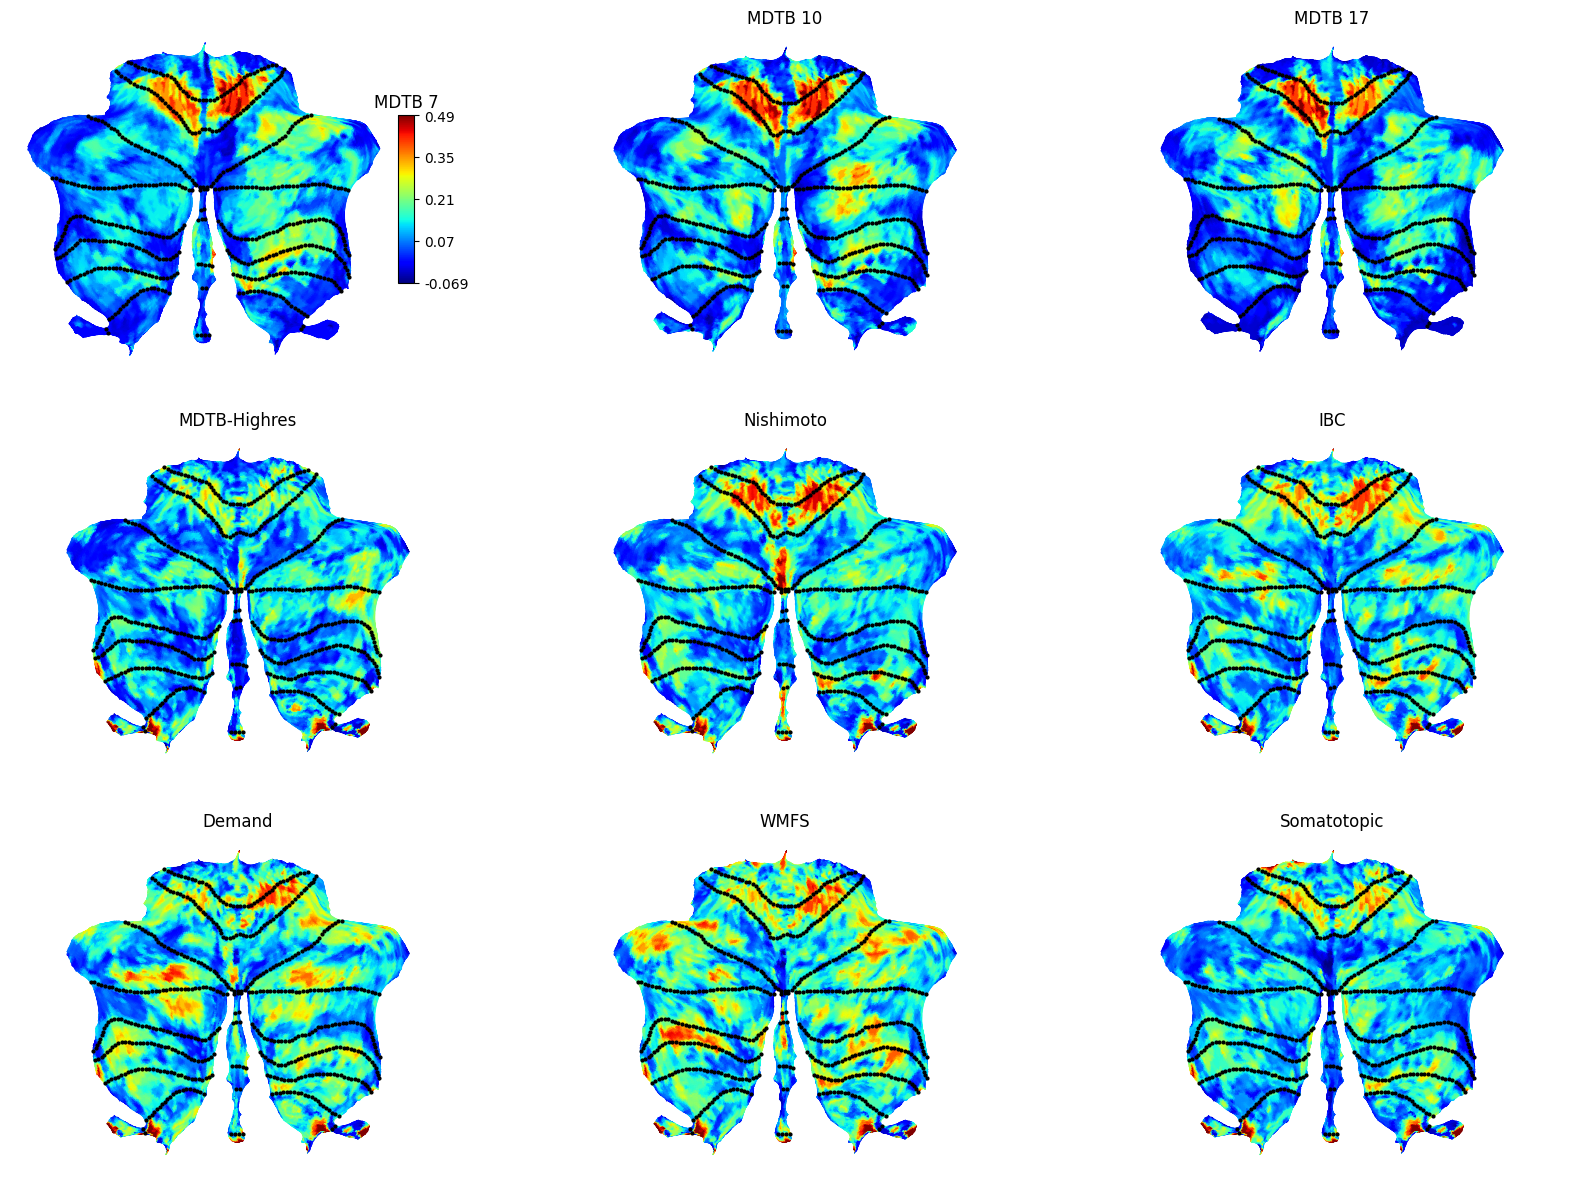

In [18]:
plt.figure(figsize=(20,20))
ut.plot_multi_flat(data=ari_all, atlas='SUIT3',
                   grid=(4, 3),
                   titles=dataset_names_all,
                   dtype='func',
                   colorbar=True)
plt.savefig(ut.figure_dir + 'NettekovenAsym32_similarity_datasetwise.png', dpi=300)

## Winner-take-all ARI

In [19]:
# Project the ARIs into the parcels and check which ARI is highest
ari_wta = np.zeros(NettekovenAsym_dseg.shape) * np.nan
for i in NettekovenAsym_dseg[NettekovenAsym_dseg > 0]:
    aris = np.nanmean(
        ari_all[:, np.where(NettekovenAsym_dseg == i)].squeeze(), axis=1)
    ari_wta[np.where(NettekovenAsym_dseg == i)] = np.argmax(aris)



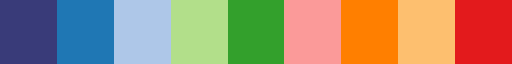

In [20]:
# Define colour map
mdtb_colours = ['#393b79', '#1f77b4', '#aec7e8']
dsets_cmap = sb.color_palette("Paired")
dsets_cmap = ['#%02x%02x%02x' % (int(r * 255), int(g * 255), int(b * 255)) for r, g, b in dsets_cmap]
new_colors = mdtb_colours + [dsets_cmap[i] for i in np.arange(2,len(dataset_names_all)-len(mdtb_colours)+2)]
# Swap the third last and last colours to have Demand & WM paired visually
new_colors[-3], new_colors[-1] = new_colors[-1], new_colors[-3]
new_cmap = ListedColormap(new_colors)
new_cmap


/Users/callithrix/code/Python/SUITPy/SUITPy/flatmap.py:354: RuntimeWarning: invalid value encountered in cast
  data_arr = data_arr.astype(int)


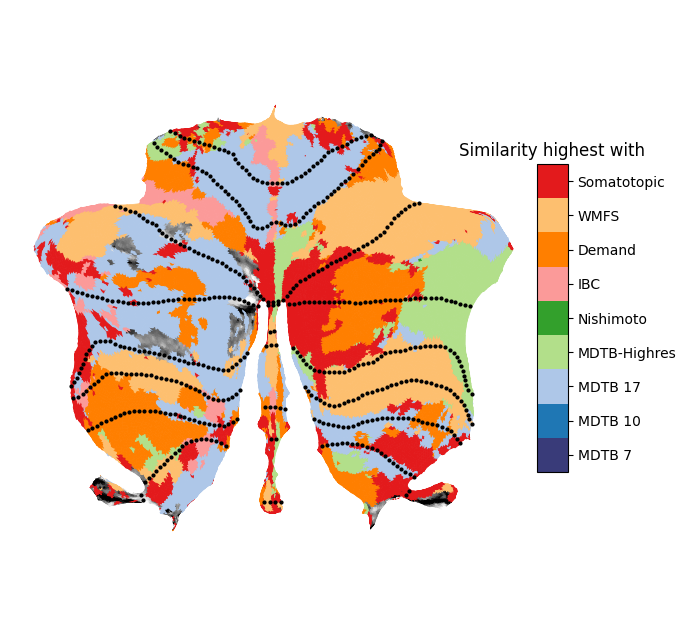

In [21]:
# Plot directly to get legend without 'None'
plt.figure(figsize=figsize)
ax = ut.plot_data_flat(data=ari_wta, atlas='SUIT3',
                   dtype='label',
                   render='matplotlib',
                   cmap=new_cmap,
                   labels=dataset_names_all,
                   bordersize=4,
                   bordercolor='k',
                   backgroundcolor='w',
                   colorbar=True)
plt.title('Similarity highest with')
plt.savefig(ut.figure_dir + 'NettekovenAsym32_similarities_legend.png', dpi=300)

In [22]:
# Account for background colour and label
ari_wta = ari_wta + 1
new_cmap = ListedColormap(['#ffffff'] + new_colors)
labels_datasets = ['None'] + dataset_names_all

In [37]:
# First project ARI & parcel assignment to surface, then prooject into labels (to ensure that ARI parcel boundaries follow the region boundaries in the surface projection)
ari_nifti = suit_atlas.data_to_nifti(ari_all)
ari_all_surf = suit.flatmap.vol_to_surf(ari_nifti, stats='nanmean', 
                                        space='SUIT')
ari_wta_surf_parcel = np.zeros(nettekoven_asym_label.shape) * np.nan

ari_wta_surf_parcel = np.zeros(nettekoven_asym_label.shape) * np.nan
for i in nettekoven_asym_label[nettekoven_asym_label > 0]:
    aris = np.nanmean(
        ari_all_surf[np.where(nettekoven_asym_label == i), :].squeeze(), axis=0)
    ari_wta_surf_parcel[np.where(nettekoven_asym_label == i)] = np.argmax(aris)


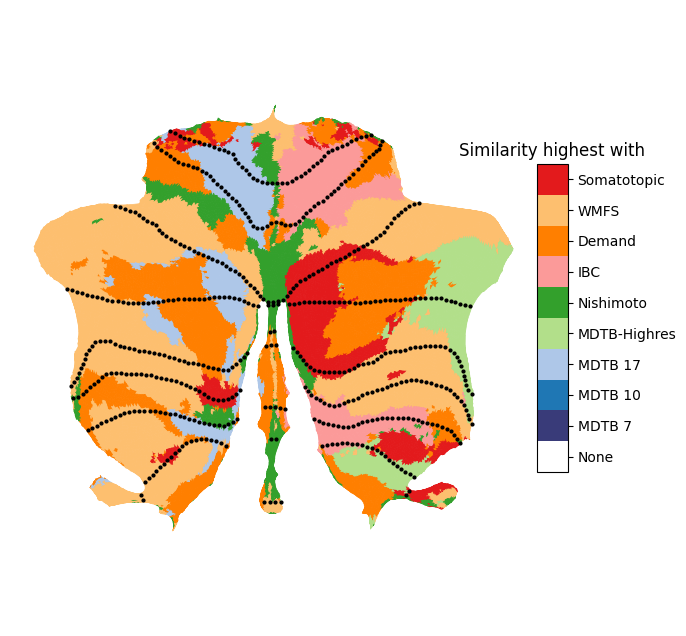

In [43]:
plt.figure(figsize=figsize)
suit.flatmap.plot(ari_wta_surf_parcel+1,
    render='matplotlib',
    cmap=new_cmap,
    new_figure=False,
    label_names=labels_datasets,
    overlay_type='label',
    colorbar=True,
    bordersize=bordersize, bordercolor=bordercolor, backgroundcolor=backgroundcolor)
plt.title('Similarity highest with')
plt.savefig(ut.figure_dir + 'NettekovenAsym32_similarities_surface.png', dpi=300)